In [12]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers


In [13]:
data = pd.read_csv('assets_wide.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
display(data)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902437,6.246624,40.000000,42.619999,26.042215,22.380075,42.757004,12.307329,20.625570,14.720884,...,28.830000,100.450676,83.888611,317.519989,69.905663,42.300953,27.664728,34.591942,33.707809,6.78375
2012-01-04,21.902437,6.246624,40.000000,42.509998,26.165096,22.380075,42.757004,12.452252,20.587936,14.581521,...,28.389999,100.608231,82.891151,318.160004,70.114944,42.300953,27.328691,34.000519,33.888031,6.69750
2012-01-05,21.902437,6.246624,40.000000,41.509998,25.814005,22.380075,42.757004,12.290606,20.459967,14.412821,...,28.510000,100.876099,82.743675,313.359985,69.817879,42.300953,26.831091,34.319897,33.472141,6.68250
2012-01-06,21.902437,6.246624,40.000000,41.349998,25.919334,22.380075,42.757004,12.128961,20.249193,14.148771,...,27.910000,100.616119,83.396851,313.760010,69.392509,42.300953,26.462749,34.207516,33.070110,6.72625
2012-01-09,21.902437,6.246624,40.000000,42.189999,25.831558,22.380075,42.757004,12.167976,20.309414,14.207447,...,28.129999,100.860359,83.249435,312.640015,69.655846,42.300953,26.663084,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196602,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [14]:
first_prices = data.apply(
    lambda col: col[col != -1].iloc[0] if (col != -1).any() else np.nan
)
fp_df = pd.DataFrame(first_prices.values, index=data.columns, columns=['First Price'])
display(fp_df.T)

normalized_close = data / first_prices
# normalized_close = normalized_close.mask(close_wide < 0, -1) 
normalized_array = normalized_close.to_numpy(dtype='float32')
print(f"normalized_array.shape {normalized_array.shape}")
display(normalized_close)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
First Price,21.902437,6.246624,40.0,42.619999,26.042215,22.380075,42.757004,12.307329,20.62557,14.720884,...,28.83,100.450676,83.888611,317.519989,69.905663,42.300953,27.664728,34.591942,33.707809,6.78375


normalized_array.shape (3408, 33)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2012-01-04,1.000000,1.000000,1.000000,0.997419,1.004719,1.000000,1.000000,1.011775,0.998175,0.990533,...,0.984738,1.001568,0.988110,1.002016,1.002994,1.000000,0.987853,0.982903,1.005347,0.987286
2012-01-05,1.000000,1.000000,1.000000,0.973956,0.991237,1.000000,1.000000,0.998641,0.991971,0.979073,...,0.988900,1.004235,0.986352,0.986898,0.998744,1.000000,0.969866,0.992136,0.993008,0.985075
2012-01-06,1.000000,1.000000,1.000000,0.970202,0.995281,1.000000,1.000000,0.985507,0.981752,0.961136,...,0.968089,1.001647,0.994138,0.988158,0.992659,1.000000,0.956552,0.988887,0.981082,0.991524
2012-01-09,1.000000,1.000000,1.000000,0.989911,0.991911,1.000000,1.000000,0.988677,0.984672,0.965122,...,0.975720,1.004078,0.992381,0.984631,0.996426,1.000000,0.963793,0.985467,0.981904,0.987102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1.747568,1.665700,2.513750,0.444158,0.542965,4.822593,1.321187,1.925682,2.012550,2.583404,...,1.039195,5.715044,1.058428,0.235828,1.845787,3.316001,2.592832,2.622807,2.215807,1.221669
2025-03-25,1.752316,1.671303,2.518000,0.440404,0.538741,4.795784,1.323292,1.934620,2.022247,2.607180,...,1.060701,5.728782,1.058310,0.235639,1.851924,3.320965,2.608376,2.593379,2.227674,1.201216
2025-03-26,1.728301,1.664899,2.454250,0.435476,0.541813,4.729206,1.311598,1.926494,2.006248,2.551477,...,1.058966,5.660390,1.051354,0.237528,1.863225,3.300044,2.571505,2.603496,2.207500,1.200663


In [15]:
print(f"normalized_size = {normalized_close.shape}")
def create_X_y(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X_window = df.iloc[i : i + window_size].values
        y_target = df.iloc[i + window_size].values
        X.append(X_window)
        y.append(y_target)
    X = np.array(X)
    y = np.array(y)
    return X, y
window_size = 30
X, y = create_X_y(normalized_close, window_size)
print(X.shape)
print(y.shape)


normalized_size = (3408, 33)
(3378, 30, 33)
(3378, 33)


In [16]:
dataset_size = len(X)
print(dataset_size)


train_size = int(dataset_size * 0.8)
test_size =int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size


X_train, X_val, X_test = X[:train_size], X[train_size: train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test= y[:train_size], y[train_size: train_size + val_size], y[train_size + val_size:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


3378


((2702, 30, 33),
 (2702, 33),
 (339, 30, 33),
 (339, 33),
 (337, 30, 33),
 (337, 33))

In [17]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  
    LSTM(64, return_sequences=False),  
    Dense(y_train.shape[1])  
])


model.compile(loss=MeanSquaredError(), 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

cp = ModelCheckpoint(filepath='model_regression/best.keras', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp, es],
)
# model.summary()



c:\Users\Shelly\Desktop\KU\18_Bachelor_project\venv_project\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.9044 - mean_squared_error: 0.9041 - val_loss: 0.2670 - val_mean_squared_error: 0.2778
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0680 - mean_squared_error: 0.0679 - val_loss: 0.1062 - val_mean_squared_error: 0.1094
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0850 - val_mean_squared_error: 0.0871
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0818 - val_mean_squared_error: 0.0839
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0823 - val_mean_squared_error: 0.0841
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0717 - val_mean_squared_error: 0.0737
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.

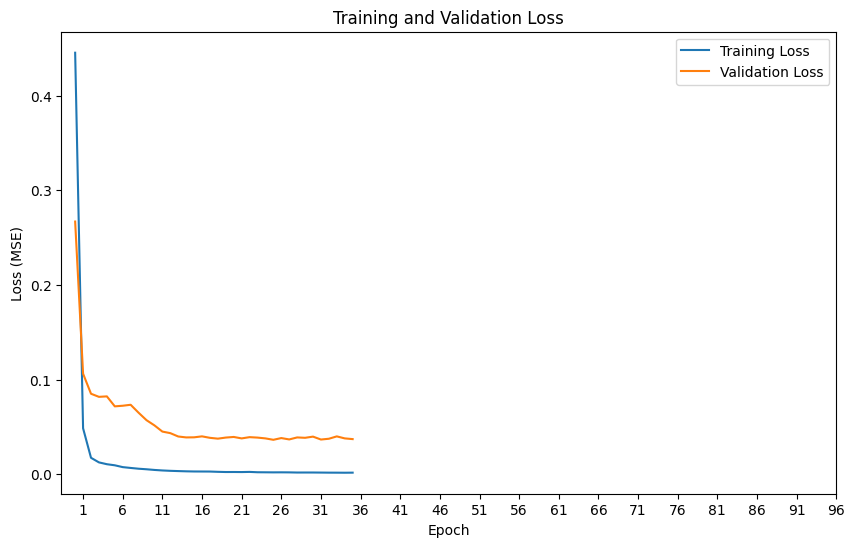

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,35.433097,12.178297,85.049744,26.873043,15.759167,92.378448,50.037334,21.161208,34.827629,25.758764,...,21.716605,407.226743,112.727741,85.175415,94.065110,98.700062,54.487814,89.613266,62.379576,7.810628
2023-12-08,35.549267,12.197618,85.882874,26.814930,15.761000,92.675578,50.131186,21.194629,34.896117,25.826153,...,21.743890,408.711983,113.386161,85.425811,93.779316,99.056367,54.666709,89.869116,62.506831,7.829430
2023-12-11,35.677179,12.220504,86.754951,26.729666,15.751132,92.984053,50.236261,21.229118,34.971668,25.907237,...,21.773834,410.216287,114.075252,85.469103,93.468063,99.430522,54.862046,90.159605,62.654185,7.848583
2023-12-12,35.802626,12.238206,87.502804,26.655013,15.757369,93.245530,50.322651,21.266967,35.038047,25.988287,...,21.790182,411.600797,114.703180,85.429501,93.140969,99.782773,55.034743,90.446052,62.792880,7.863252
2023-12-13,35.898122,12.251090,88.173513,26.575708,15.770779,93.465099,50.387363,21.287357,35.092179,26.042937,...,21.793254,412.742891,115.265837,85.335781,92.857542,100.065898,55.178667,90.651354,62.912348,7.874509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,39.719721,13.470987,111.785402,24.114706,13.933134,101.914177,55.663071,22.801158,36.696561,30.291524,...,22.804592,440.639380,128.199408,71.969634,76.347917,109.771196,61.049189,99.309170,69.224321,8.468359
2025-03-25,39.737186,13.475666,111.846685,24.121997,13.923647,101.933567,55.717905,22.806237,36.689384,30.292222,...,22.804133,440.811001,128.250809,72.179094,76.391401,109.790066,61.076608,99.315504,69.220584,8.468768
2025-03-26,39.762063,13.477712,111.903591,24.116601,13.903700,101.963405,55.744853,22.809892,36.686107,30.295890,...,22.804991,441.011887,128.288500,72.324178,76.397560,109.818274,61.109112,99.352394,69.217932,8.467990


<Axes: xlabel='Date'>

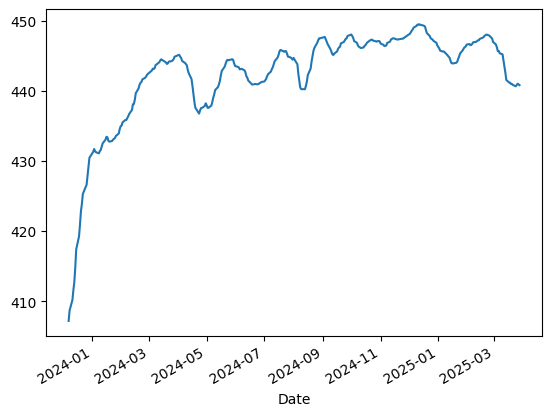

In [19]:
model = load_model('model_regression/best.keras')
index_series = data.index[train_size + val_size + window_size:]

Y_pred = model.predict(X_test)
Y_pred_denorm = Y_pred * first_prices.values
Predict_result_df = pd.DataFrame(Y_pred_denorm, index=index_series, columns=data.columns)

display(Predict_result_df)

Predict_result_df["SPY"].plot()


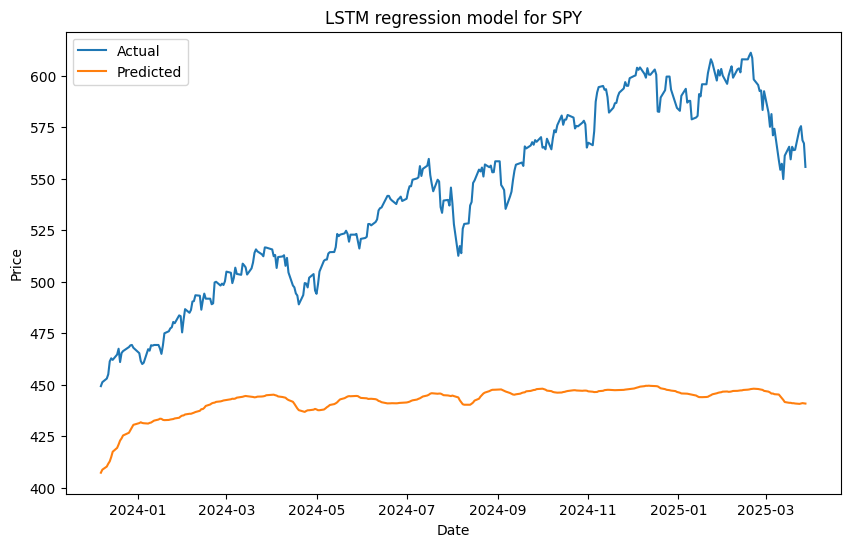

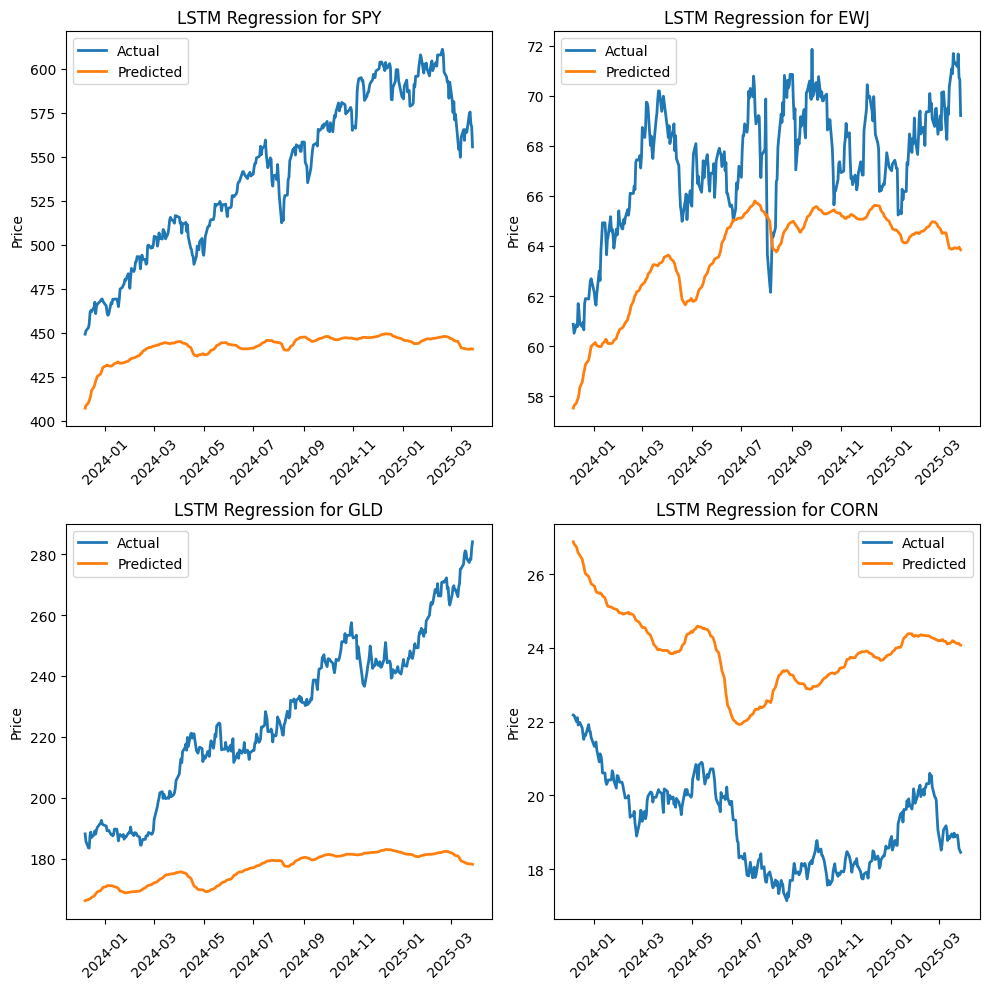

In [20]:
y_test_denorm = y_test * first_prices.values
y_actual = pd.DataFrame(y_test_denorm, index=index_series, columns=data.columns)
ticker_name = 'SPY'

plt.figure(figsize=(10,6))
plt.plot(y_actual[ticker_name], label='Actual')
plt.plot(Predict_result_df[ticker_name], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM regression model for {ticker_name}')
plt.legend()
plt.show()




ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  # example tickers, adjust as needed

# Define layout
num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten()  # Flatten in case of single row

# Plot each ticker
for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Predict_result_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

# Remove any empty subplots if the number of tickers is less than the number of subplots
for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [21]:
print("Mean of actual normalized prices:", np.mean(y_test))
print("Mean of predicted normalized prices:", np.mean(Y_pred))


Mean of actual normalized prices: 1.991787475412965
Mean of predicted normalized prices: 1.9003885


In [22]:
yesterday_prices = data.iloc[-2]  
today_prices_actual = data.iloc[-1] 

Y_pred_mean = Y_pred_denorm.mean(axis=0)
today_prices_predicted = pd.Series(Y_pred_mean.flatten(), index=data.columns)


comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_pred': today_prices_predicted,
})

tickers_names = data.columns

correct_list = []
for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]

    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)

    if sign_actual == sign_pred:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list

count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
# display(comparison_df)
save_df = pd.DataFrame()
save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
save_df['Today pred target'] = comparison_df['Today_pred'].apply(lambda x: round(x, 2))
save_df['Correct'] = comparison_df['Correct']
display(save_df)
save_df.to_csv('rnn_regression.csv', index=True)


Count of correct predictions: 24
accuracy: 0.7272727272727273


,Yesterday actual,Today actual,Today pred target,Correct
AIEQ,37.66,36.85,39.76,0
ASHR.L,10.46,10.34,13.29,0
BCHN.L,97.08,92.71,110.62,0
CORN,18.51,18.46,23.92,0
DBO,14.13,13.97,13.82,1
EDEN,105.33,105.17,102.10,1
EMXC,56.11,55.18,54.88,1
EWA,23.75,23.47,22.57,1
EWC,41.25,40.57,36.52,1
EWG,37.59,37.39,29.74,1
